In [12]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target


In [14]:
from constants import myDataImg, myDataCoco


# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir=myDataImg,
    ann_file=myDataCoco
)


val_dataset = get_coco_dataset(
    img_dir=myDataImg,
    ann_file=myDataCoco
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [15]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [16]:
# Initialize the model
num_classes = 11 # Background + categories
model = get_model(num_classes)

In [17]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [18]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")



In [19]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Save the model's state dictionary after every epoch
    model_path = f'fasterrcnn_resnet50_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")


Epoch [0] Loss: 1.9997
Model saved: fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 1.5720
Model saved: fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 1.2752
Model saved: fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 1.4680
Model saved: fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 1.3442
Model saved: fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 1.1699
Model saved: fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 1.4439
Model saved: fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 1.3209
Model saved: fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 1.2814
Model saved: fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 1.1796
Model saved: fasterrcnn_resnet50_epoch_10.pth


[[ 264.5876  1120.666    296.2124  1173.7136 ]
 [1572.5623  1097.4103  1604.7489  1153.473  ]
 [ 454.69122 2401.9507   487.28732 2462.4453 ]
 [ 731.6745   532.9377   763.7731   586.9081 ]
 [1725.0447  1837.9211  1759.5242  1891.8783 ]
 [1046.2917  1097.7294  1078.8959  1161.261  ]
 [1078.8228  1845.7861  1112.5675  1896.9641 ]
 [1379.9502  1795.1554  1407.7598  1853.2228 ]
 [1221.3679  2410.2673  1255.364   2476.311  ]
 [ 628.2874  1103.2101   662.0002  1155.8424 ]
 [ 819.8969  2261.9695   854.03235 2325.0022 ]
 [ 911.1759  1539.2697   944.2276  1597.1064 ]
 [1679.4602  1096.8401  1710.0789  1153.3114 ]
 [ 274.53766 1392.0135   308.4154  1452.721  ]
 [1169.1348  1096.5345  1199.7454  1153.4275 ]
 [ 922.254   2276.6165   956.28107 2332.5605 ]
 [ 643.8166  1964.3503   678.13855 2026.2722 ]
 [ 263.6178  1964.0961   297.3778  2014.8661 ]
 [ 338.368   1389.2574   367.10544 1448.1075 ]
 [ 274.60092 1820.6672   308.09164 1886.0742 ]
 [ 929.4612  1811.991    960.0582  1872.8049 ]
 [ 775.66425 

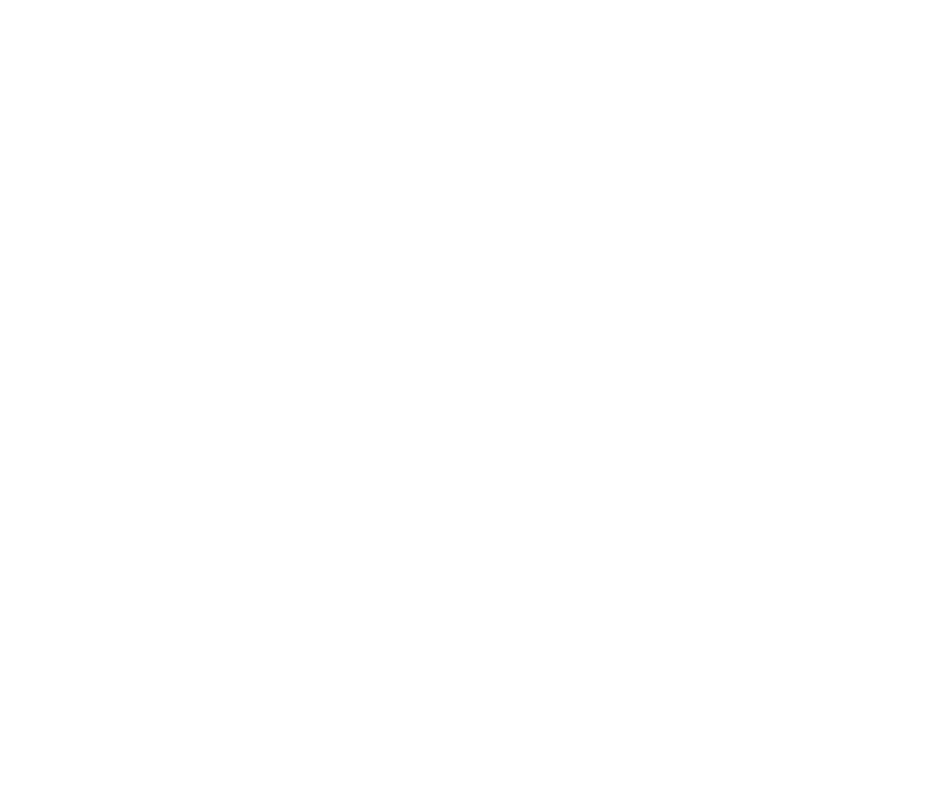

In [21]:
from constants import *
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 11  # Background + chair + person + table

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load(r'C:\Users\Usuario\Desktop\UDC\QUINTO\TFG\src_code\learning\FasterRCNN\fasterrcnn_resnet50_epoch_10.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = feelTheLove
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "One", 2: "Double", 3: "Four", 4: "Half", 5: "Quarter", 6: "GClef", 7: "FClef", 8: "OpeningBracket", 9: "RestOne", 10: "RestHalf"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    print(boxes)
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5
    
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size
